In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import GroverOperator
from hcd_clc_uncompute import create_hcd_clc_uncompute_oracle
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from scipy.stats import entropy


def run_grover_iterations(full_run=True):
    # --- Parameters ---
    t = 6
    initial_threshold = 13
    min_threshold = 1
    max_iterations = initial_threshold - min_threshold + 1
    backend = Aer.get_backend('qasm_simulator')

    # Tracking variables
    entropy_history = [np.inf]
    winner_counts = []
    thresholds_used = []

    for iteration in range(max_iterations):
        threshold = initial_threshold - iteration
        thresholds_used.append(threshold)

        # Quantum Registers
        precision = QuantumRegister(t, 't')        
        cth_flag = QuantumRegister(1, 'cth_flag')          
        hamiltonian_flag = QuantumRegister(1, 'hamiltonian_flag')
        ancillary = QuantumRegister(5, 'ancillary')
        cycle = QuantumRegister(8, 'C')            
        
        # Classical register
        classical_bits = ClassicalRegister(len(cycle), 'c')
        
        # Oracle and Grover operator
        hcd_clc_uncompute_oracle = create_hcd_clc_uncompute_oracle(threshold)
        reflection_qubits = list(range(13, 21))  # adjust if needed
        grover_op = GroverOperator(hcd_clc_uncompute_oracle, reflection_qubits=reflection_qubits)
        
        # Circuit construction
        qc = QuantumCircuit(precision, cth_flag, hamiltonian_flag, ancillary, cycle, classical_bits)
        for i in reflection_qubits:
            qc.h(i)
        
        qc.compose(grover_op.power(8), inplace=True)
        qc.measure(cycle, classical_bits)

        # Run circuit
        compiled = transpile(qc, backend)
        result = backend.run(compiled, shots=1024).result()
        counts = result.get_counts()

        # Compute entropy
        probs = np.array(list(counts.values())) / sum(counts.values())
        H = entropy(probs, base=2)
        print(f"Iteration {iteration+1}, Threshold {threshold}, Entropy: {H:.4f}")
        
        # Entropy jump check
        prev_H = entropy_history[-1]
        if not full_run and H > prev_H * 1.2:
            print(f"Entropy jumped more than 20% from {prev_H:.4f} to {H:.4f}. Breaking loop.")
            break

        # Append entropy and winner count
        entropy_history.append(H)
        winners = sum(1 for v in counts.values() if v > 200)
        winner_counts.append(winners)
        print(f"Winner States (count > 200): {winners}")

        # Plot top results
        N = 10
        top_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)[:N])
        plot_histogram(top_counts, title=f"Top {N} Results - Iteration {iteration+1} - Threshold {threshold}")
        plt.show()

    # Plot results
    iterations = list(range(1, len(entropy_history)))  # skip the initial inf
    plt.figure(figsize=(12, 6))
    plt.plot(iterations, entropy_history[1:], marker='o', label='Entropy')
    plt.plot(iterations, winner_counts, marker='s', label='Winner Count (>200)')
    plt.plot(iterations, thresholds_used[:len(iterations)], marker='^', label='Threshold Used')
    plt.xlabel('Iteration')
    plt.title(f'Entropy, Winner Count, and Threshold per Iteration (Full Run: {full_run})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


=== Running with full_run=True ===
Iteration 1, Threshold 13, Entropy: 7.2290
Winner States (count > 200): 0


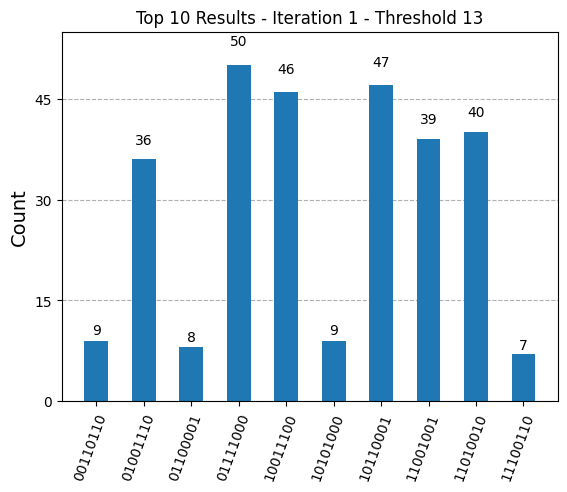

Iteration 2, Threshold 12, Entropy: 6.0616
Winner States (count > 200): 0


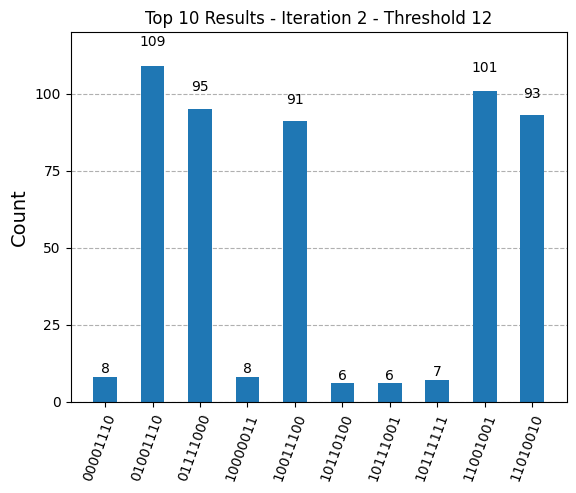

Iteration 3, Threshold 11, Entropy: 6.2210
Winner States (count > 200): 0


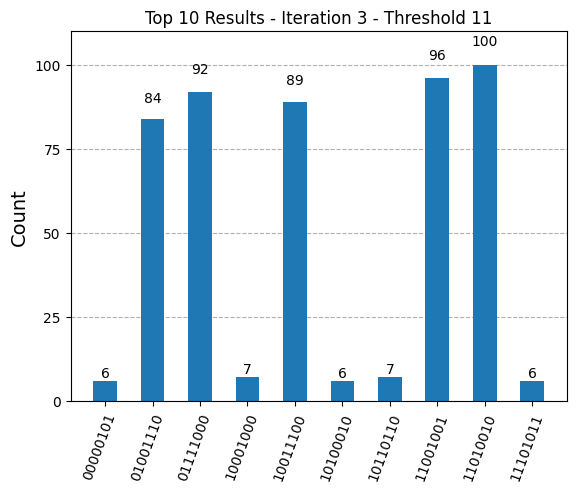

Iteration 4, Threshold 10, Entropy: 6.1906
Winner States (count > 200): 0


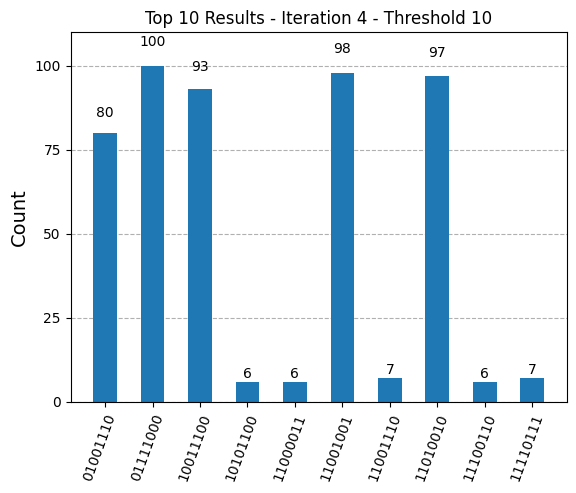

Iteration 5, Threshold 9, Entropy: 2.2302
Winner States (count > 200): 3


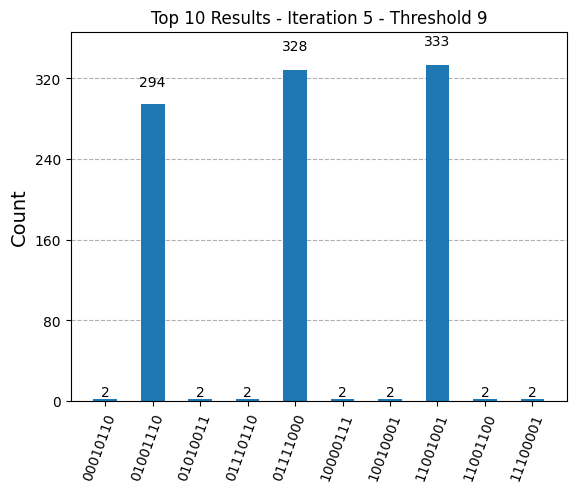

Iteration 6, Threshold 8, Entropy: 2.3874
Winner States (count > 200): 3


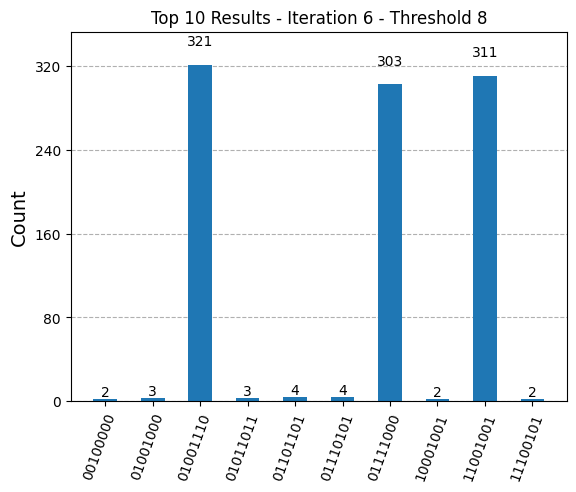

Iteration 7, Threshold 7, Entropy: 2.4181
Winner States (count > 200): 3


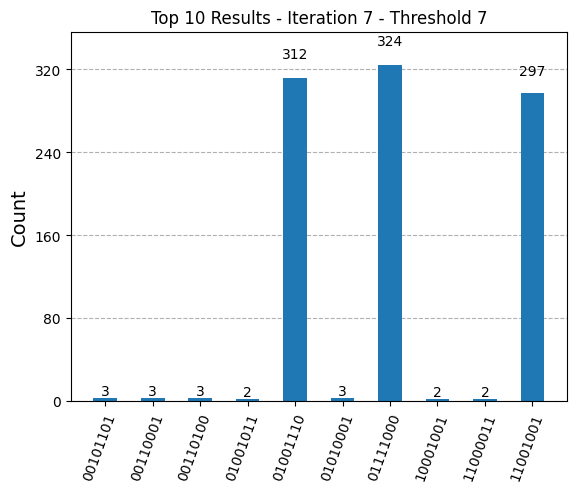

Iteration 8, Threshold 6, Entropy: 1.0713
Winner States (count > 200): 2


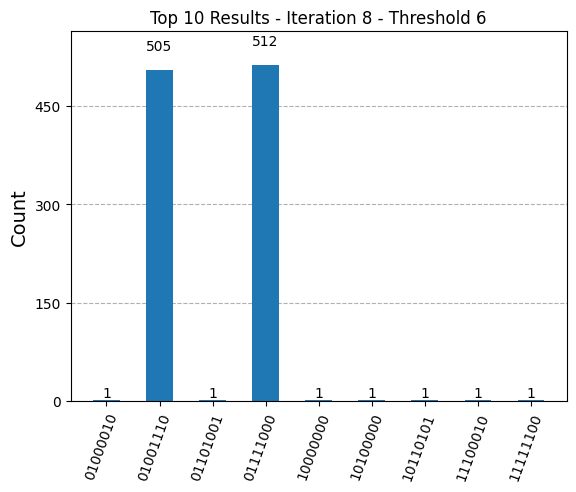

Iteration 9, Threshold 5, Entropy: 7.8196
Winner States (count > 200): 0


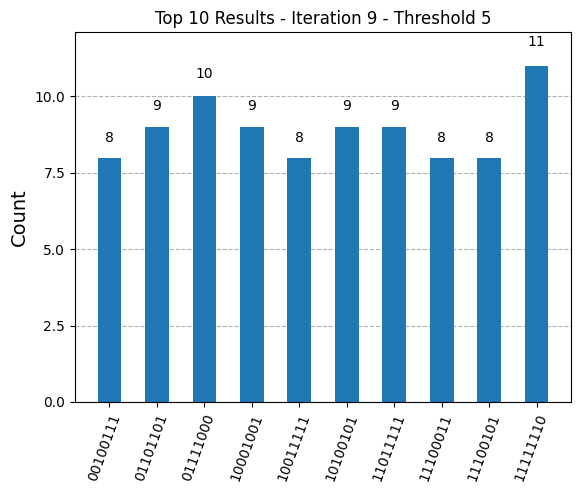

Iteration 10, Threshold 4, Entropy: 7.7995
Winner States (count > 200): 0


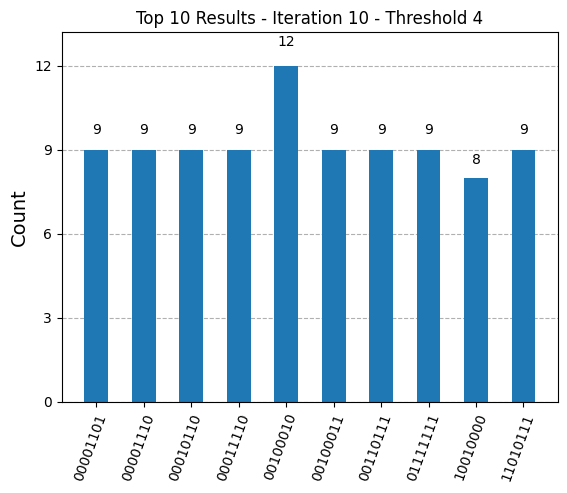

Iteration 11, Threshold 3, Entropy: 7.8055
Winner States (count > 200): 0


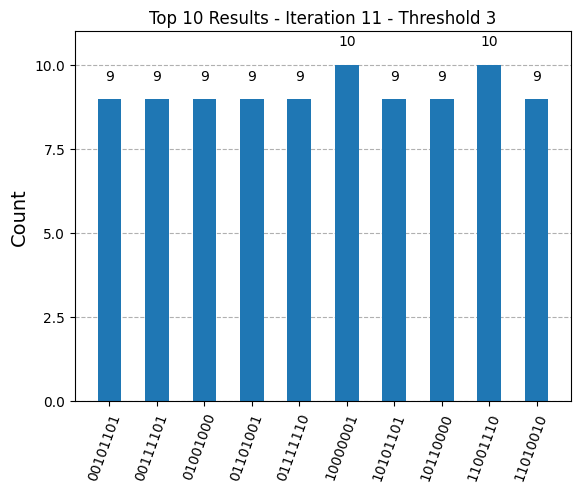

Iteration 12, Threshold 2, Entropy: 7.8505
Winner States (count > 200): 0


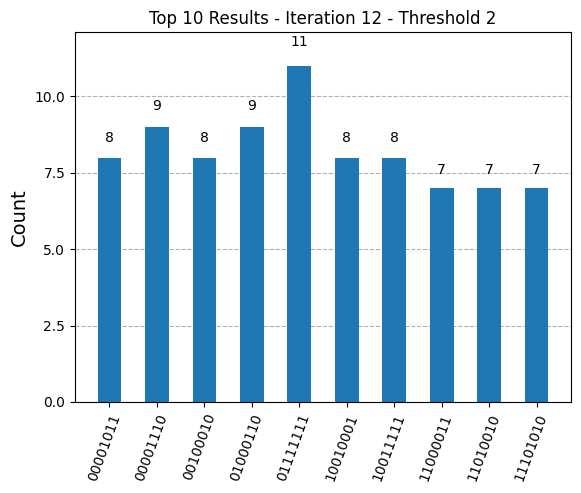

Iteration 13, Threshold 1, Entropy: 7.8248
Winner States (count > 200): 0


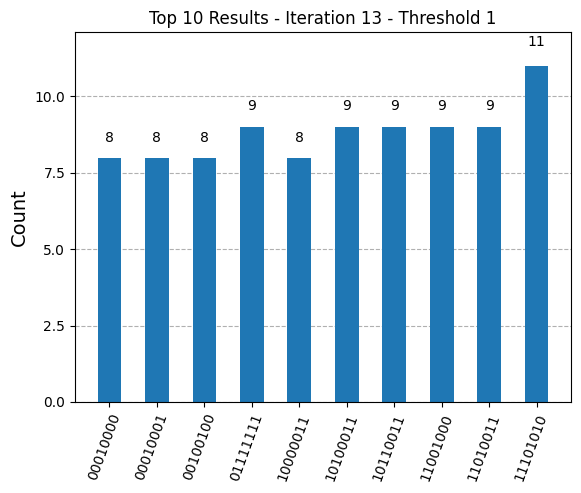

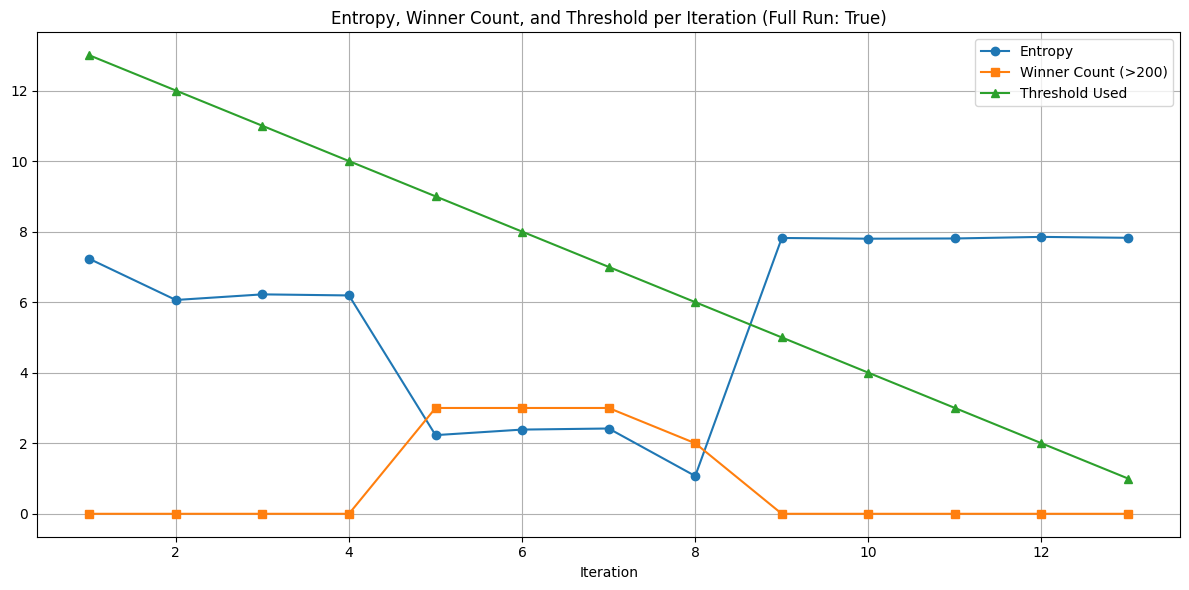

In [2]:
# Call the function twice
print("=== Running with full_run=True ===")
run_grover_iterations(full_run=True)


=== Running with full_run=False ===
Iteration 1, Threshold 13, Entropy: 7.2163
Winner States (count > 200): 0


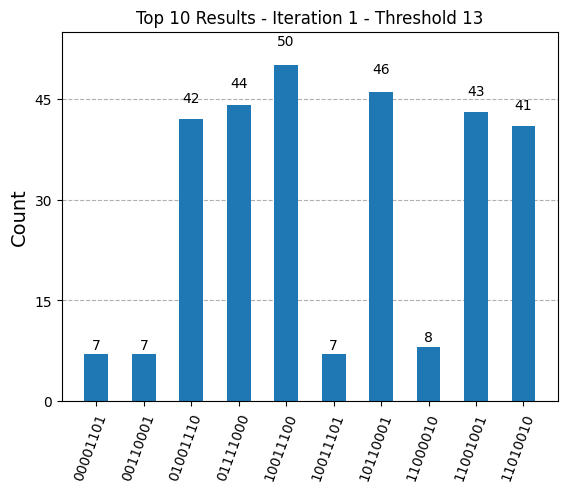

Iteration 2, Threshold 12, Entropy: 6.0738
Winner States (count > 200): 0


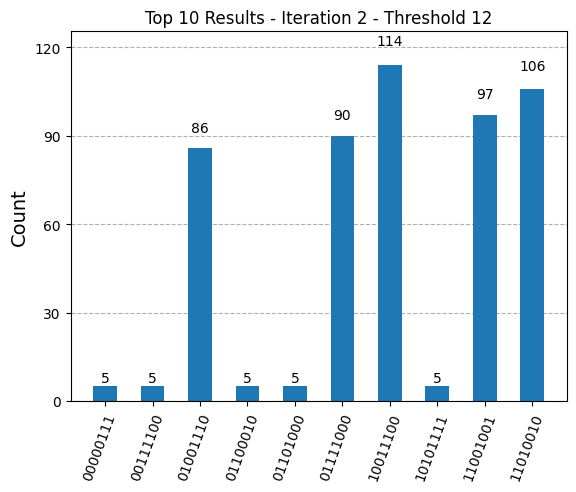

Iteration 3, Threshold 11, Entropy: 6.0768
Winner States (count > 200): 0


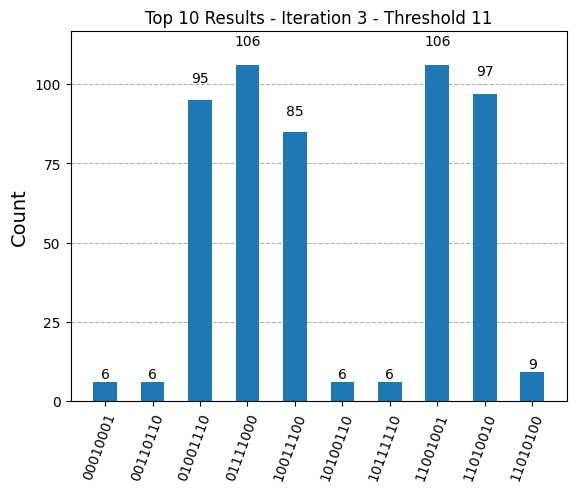

Iteration 4, Threshold 10, Entropy: 6.1506
Winner States (count > 200): 0


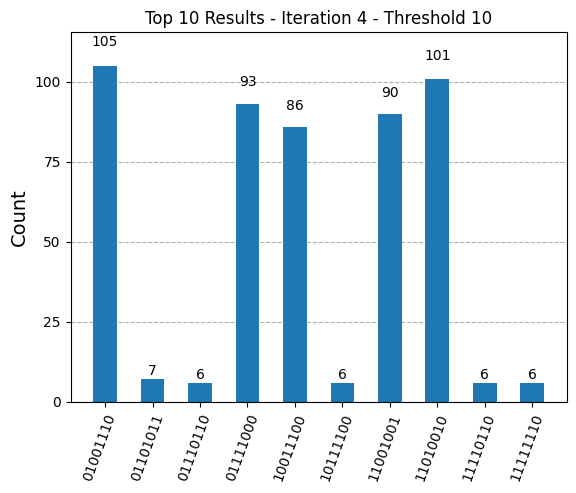

Iteration 5, Threshold 9, Entropy: 2.5129
Winner States (count > 200): 3


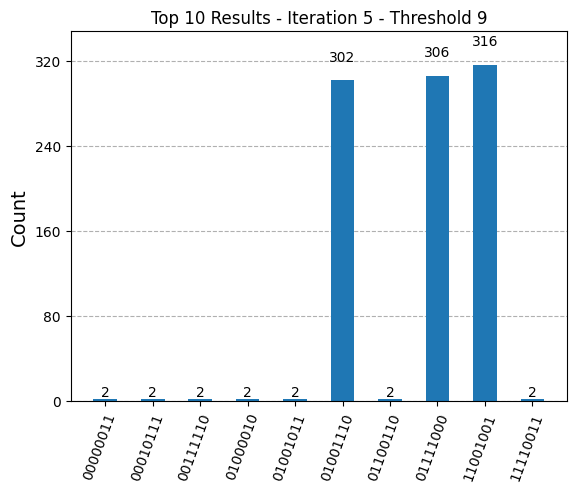

Iteration 6, Threshold 8, Entropy: 2.2375
Winner States (count > 200): 3


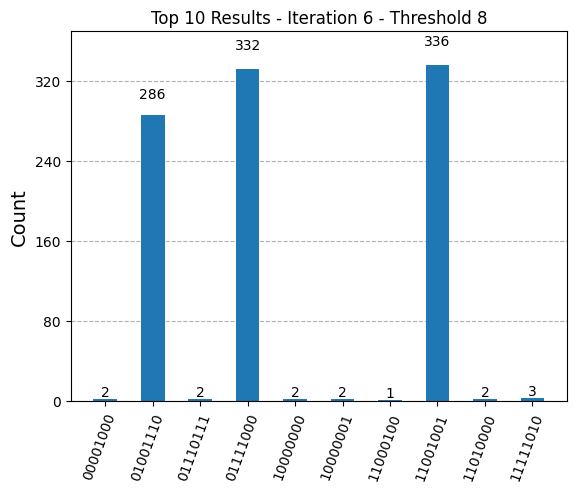

Iteration 7, Threshold 7, Entropy: 2.2423
Winner States (count > 200): 3


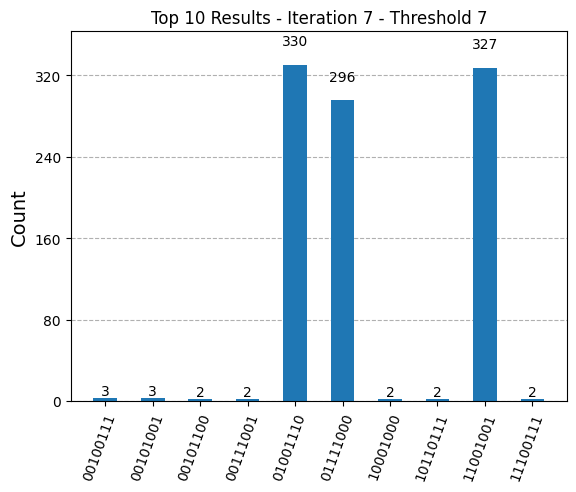

Iteration 8, Threshold 6, Entropy: 1.0695
Winner States (count > 200): 2


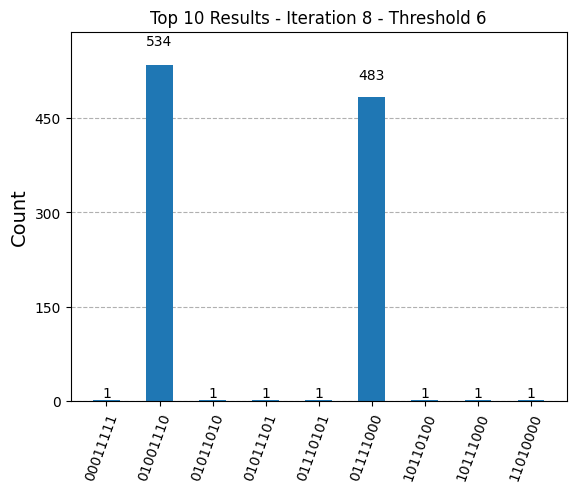

Iteration 9, Threshold 5, Entropy: 7.8138
Entropy jumped more than 20% from 1.0695 to 7.8138. Breaking loop.


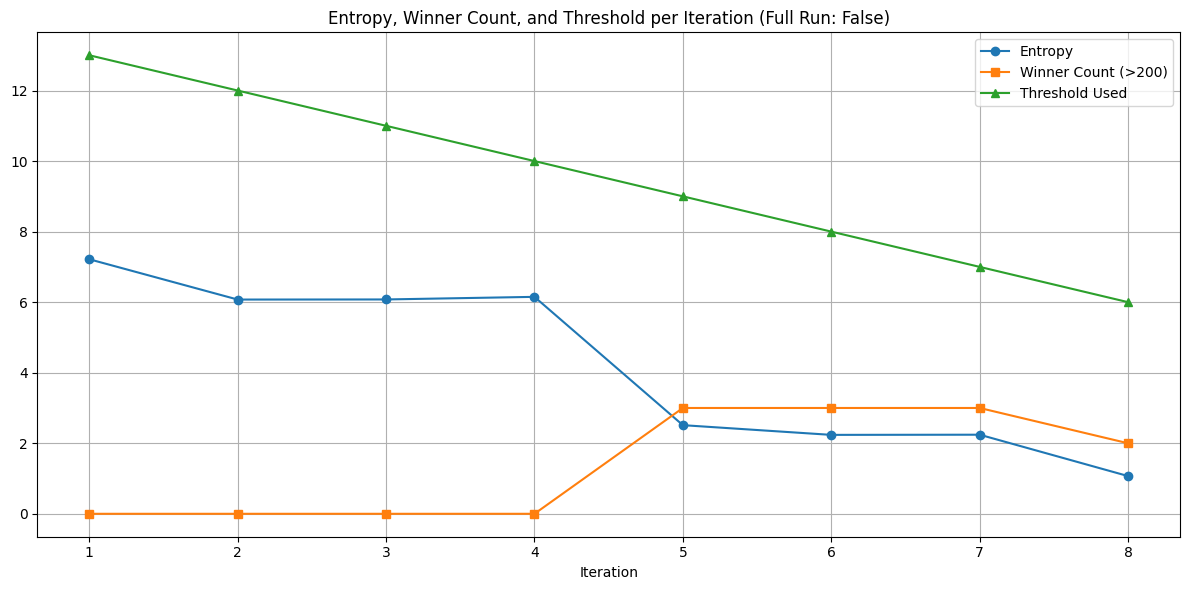

In [3]:
print("\n=== Running with full_run=False ===")
run_grover_iterations(full_run=False)